## Environment setup

In [64]:
import sys

try:
    import torch
except ImportError as e:
    !{sys.executable} -m pip install torch
    
try:
    import torchvision
except ImportError as e:
    !{sys.executable} -m pip install torchvision
    
try:
    import cv2
except ImportError as e:
    !{sys.executable} -m pip install opencv-python

## Data Splitting

In [65]:
import os
import myutils

path2data = "./data"
sub_folder_jpg = "JPG"
path2ajpgs = os.path.join(path2data, sub_folder_jpg)

In [66]:
all_vids, all_labels, catgs = myutils.get_vids(path2ajpgs) 
len(all_vids), len(all_labels), len(catgs)

(49601, 49601, 2)

In [67]:
all_vids[:1], all_labels[:3], catgs[:5]

(['./data\\JPG\\class1\\1.2.840.4267.32.100205641784865286778089171315423724299_1.2.840.4267.32.101117583856522992390914413218921289296'],
 ['class1', 'class1', 'class1'],
 ['class1', 'class2'])

In [68]:
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1
labels_dict 

{'class1': 0, 'class2': 1}

In [69]:
num_classes = 2
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label]<num_classes]
len(unique_ids),len(unique_labels)

(49601, 49601)

In [70]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels)) 

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

44640 44640
4961 4961


In [71]:
train_ids[:5], train_labels[:5]

(['./data\\JPG\\class1\\1.2.840.4267.32.119381312585533108913160209931977392780_1.2.840.4267.32.38559680277235543919864052537568576421',
  './data\\JPG\\class1\\1.2.840.4267.32.265711015189567804437153476169849110909_1.2.840.4267.32.22160995663413375376894726021653934102',
  './data\\JPG\\class1\\1.2.840.4267.32.176744874339194075697310560757184575710_1.2.840.4267.32.40268244373659034584159498589366229663',
  './data\\JPG\\class1\\1.2.840.4267.32.286850557785391267403743054087731216405_1.2.840.4267.32.103226457266071192946150830387155455284',
  './data\\JPG\\class1\\1.2.840.4267.32.246231101474948700965139031568347447981_1.2.840.4267.32.59647607857813191777932220515088243796'],
 ['class1', 'class1', 'class1', 'class1', 'class1'])

In [72]:
test_ids[:5], test_labels[:5]

(['./data\\JPG\\class1\\1.2.840.4267.32.250582045599238908700695009391998342849_1.2.840.4267.32.207428153282428959181018790991719874282',
  './data\\JPG\\class1\\1.2.840.4267.32.104222905627470323645661742742854599078_1.2.840.4267.32.28564813183294140935959726316403903940',
  './data\\JPG\\class1\\1.2.840.4267.32.254528893787626419406117554209601903499_1.2.840.4267.32.83093578683269727869866364065725636281',
  './data\\JPG\\class2\\1.2.840.4267.32.32902321765581074646601124172207152722_1.2.840.4267.32.177919705780059896107240109841025741131',
  './data\\JPG\\class1\\1.2.840.4267.32.193832509637360172246614032901858896276_1.2.840.4267.32.314026772664573594779999185292000400556'],
 ['class1', 'class1', 'class1', 'class2', 'class1'])

## Defining Dataset

In [73]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):      
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path2imgs=glob.glob(self.ids[idx]+"/*.jpg")
        path2imgs = path2imgs[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)
        
        seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label

In [74]:
# choose one
#model_type = "3dcnn"
model_type = "rnn"    

timesteps =16
if model_type == "rnn":
    h, w =224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    h, w = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

In [75]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),  
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),    
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])     

In [76]:
train_ds = VideoDataset(ids= train_ids, labels= train_labels, transform= train_transformer)
print(len(train_ds))

44640


In [77]:
imgs, label = train_ds[10]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 1, tensor(-2.1179), tensor(2.6400))

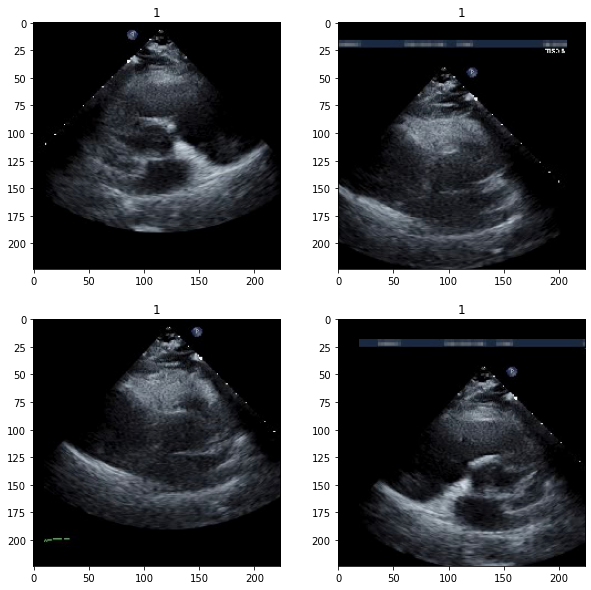

In [78]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

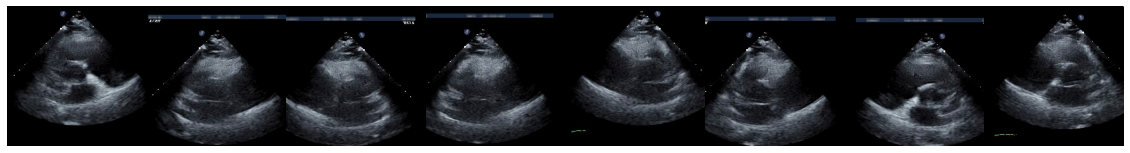

In [79]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for ii,img in enumerate(imgs[::2]):
    plt.subplot(1,8,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.axis("off")

In [80]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ]) 
test_ds = VideoDataset(ids= test_ids, labels= test_labels, transform= test_transformer)
print(len(test_ds))

4961


In [81]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([16, 3, 224, 224]), 0, tensor(-2.1179), tensor(2.6400))

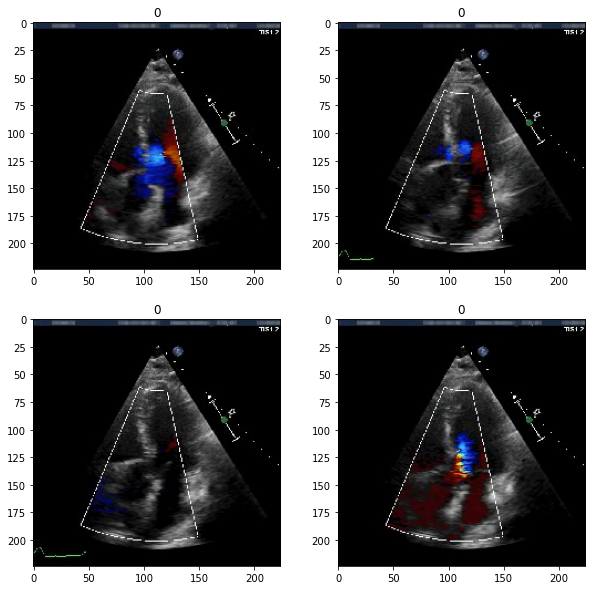

In [82]:
plt.figure(figsize=(10,10))
for ii,img in enumerate(imgs[::4]):
    plt.subplot(2,2,ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

## Defining Data Loaders

In [83]:
def collate_fn_r3d_18(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor

def collate_fn_rnn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor
    

batch_size = 1
if model_type == "rnn":
    train_dl = DataLoader(train_ds, batch_size= batch_size,
                          shuffle=True, collate_fn= collate_fn_rnn)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size,
                         shuffle=False, collate_fn= collate_fn_rnn)  
else:
    train_dl = DataLoader(train_ds, batch_size= batch_size, 
                          shuffle=True, collate_fn= collate_fn_r3d_18)
    test_dl = DataLoader(test_ds, batch_size= 2*batch_size, 
                         shuffle=False, collate_fn= collate_fn_r3d_18)          

In [84]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([1, 16, 3, 224, 224]) torch.Size([1])


In [85]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([2, 16, 3, 224, 224]) torch.Size([2])


## Defining Model

In [86]:
from torch import nn
class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnt18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        baseModel = models.resnet18(pretrained=pretrained)
        num_features = baseModel.fc.in_features
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0
        y = self.baseModel((x[:,ii]))
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        for ii in range(1, ts):
            y = self.baseModel((x[:,ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
        out = self.dropout(out[:,-1])
        out = self.fc1(out) 
        return out 
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x    

In [87]:
from torchvision import models
from torch import nn

if model_type == "rnn":
    params_model={
        "num_classes": num_classes,
        "dr_rate": 0.1,
        "pretrained" : True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,}
    model = Resnt18Rnn(params_model)        
else:
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

C:\Users\islam\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\islam\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
with torch.no_grad():
    if model_type=="rnn":
        x = torch.zeros(1, 16, 3, h, w)
    else:
        x = torch.zeros(1, 3, 16, h, w)
    y= model(x)
    print(y.shape)

torch.Size([1, 2])


In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [90]:
model

Resnt18Rnn(
  (baseModel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [91]:
path2weights = "./models/weights.pt"
torch.save(model.state_dict(), path2weights)

## Training Model

In [92]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=5,verbose=1)
os.makedirs("./models", exist_ok=True)

params_train={
    "num_epochs": 20,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": "./models/weights_"+model_type+".pt",
    }
model,loss_hist,metric_hist = myutils.train_val(model,params_train)

Epoch 0/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000015, dev loss: 0.000236, accuracy: 0.04
----------
Epoch 1/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000014, dev loss: 0.000279, accuracy: 0.02
----------
Epoch 2/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.000013, dev loss: 0.000200, accuracy: 0.04
----------
Epoch 3/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000012, dev loss: 0.000290, accuracy: 0.02
----------
Epoch 4/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000016, dev loss: 0.000238, accuracy: 0.04
----------
Epoch 5/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000013, dev loss: 0.000256, accuracy: 0.02
----------
Epoch 6/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000016, dev loss: 0.000257, accuracy: 0.04
----------
Epoch 7/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000018, dev loss: 0.000260, accuracy: 0.04
----------
Epoch 8/19, current lr=3e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.5000e-05.
Loading best model weights!
train loss: 0.000013, dev loss: 0.000242, accuracy: 0.04
----------
Epoch 9/19, current lr=1.5e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000014, dev loss: 0.000232, accuracy: 0.04
----------
Epoch 10/19, current lr=1.5e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000013, dev loss: 0.000238, accuracy: 0.04
----------
Epoch 11/19, current lr=1.5e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000014, dev loss: 0.000233, accuracy: 0.04
----------
Epoch 12/19, current lr=1.5e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000012, dev loss: 0.000251, accuracy: 0.04
----------
Epoch 13/19, current lr=1.5e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000015, dev loss: 0.000219, accuracy: 0.04
----------
Epoch 14/19, current lr=1.5e-05


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 7.5000e-06.
Loading best model weights!
train loss: 0.000018, dev loss: 0.000279, accuracy: 0.02
----------
Epoch 15/19, current lr=7.5e-06


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000014, dev loss: 0.000332, accuracy: 0.00
----------
Epoch 16/19, current lr=7.5e-06


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000017, dev loss: 0.000343, accuracy: 0.00
----------
Epoch 17/19, current lr=7.5e-06


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000014, dev loss: 0.000239, accuracy: 0.04
----------
Epoch 18/19, current lr=7.5e-06


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000019, dev loss: 0.000247, accuracy: 0.04
----------
Epoch 19/19, current lr=7.5e-06


  0%|          | 0/44640 [00:00<?, ?it/s]

  0%|          | 0/2481 [00:00<?, ?it/s]

train loss: 0.000016, dev loss: 0.000263, accuracy: 0.04
----------


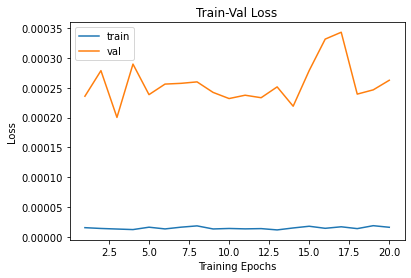

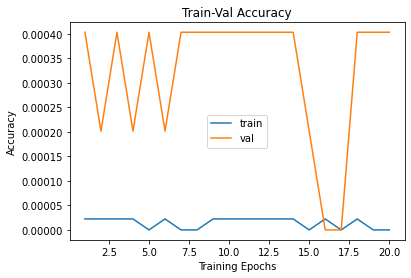

In [93]:
myutils.plot_loss(loss_hist, metric_hist)